In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Viewing images
from ipywidgets import interact
import matplotlib.pyplot as plt

# Classification
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Scene ID
from matplotlib.patches import Rectangle

# Importing and Formatting Data

In [2]:
# Image data stored in the data column. 
# Stored as a list of 6400*3 ints. First 6400 are red, next are green, the blue. 
# Images are 80x80px
data_json = pd.read_json('shipsnet.json')
data_json.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
rgbs = data_json['data']
rgbs.head()

0    [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...
1    [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...
2    [125, 127, 129, 130, 126, 125, 129, 133, 132, ...
3    [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...
4    [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...
Name: data, dtype: object

In [4]:
rgbs = np.stack(rgbs) # Make 2d np array
r = rgbs[:,:6400]
g = rgbs[:,6400:6400*2]
b = rgbs[:,6400*2:]
r.shape, g.shape, b.shape

((4000, 6400), (4000, 6400), (4000, 6400))

$$Black\ and\ white = \frac{r + g + b}{3}$$

In [5]:
black_white = (r+g+b)/3
# black_white = black_white.reshape([4000, 80, 80])
black_white.shape

(4000, 6400)

# Viewing Images

In [6]:
def browse_images(images, labels, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
browse_images(black_white.reshape([4000, 80, 80]), data_json['labels'], ['Not Boat', 'Boat'])

interactive(children=(IntSlider(value=1999, description='i', max=3999), Output()), _dom_classes=('widget-interact',))

# Applying Model

In [7]:
# Split data
test_vectors, train_vectors, test_labels, train_labels = train_test_split(black_white, data_json['labels'],test_size=0.8, train_size=0.2)


In [8]:
rerun_training = False
if rerun_training:
    # Best parameters found{'C': 1000.0, 'kernel': 'linear', 'gamma': 0.0001}
    start = time.time()

    #make some temporary variables so you can change this easily
    tmp_vectors = train_vectors
    tmp_labels = train_labels

    print("Fitting the classifier to the training set")
    # a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                  'kernel': ['linear']}
    # make a classifier by searching over a classifier and the parameter grid
    clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)

    # we have a "good" classifier (according to GridSearchCV), how's it look
    clf = clf.fit(tmp_vectors, tmp_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    print("Best parameters found by grid search:")
    print(clf.best_params_)

    end = time.time()
    print("Runtime",end - start)

    pickle.dump(clf, open('best_classifier.p', 'wb'))
else:
    clf = pickle.load(open('best_classifier.p', 'rb'))

In [9]:
predictions = clf.predict(test_vectors)

In [10]:
sum(predictions == test_labels)/len(test_labels) # First run was 86% accurate.

0.97875

In [11]:
print(classification_report(test_labels, predictions))
print(confusion_matrix(test_labels, predictions, labels=range(2)))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       600
          1       0.94      0.98      0.96       200

avg / total       0.98      0.98      0.98       800

[[587  13]
 [  4 196]]


In [12]:
browse_images(test_vectors.reshape(800,80,80), predictions, ['Not Boat', 'Boat'])

interactive(children=(IntSlider(value=399, description='i', max=799), Output()), _dom_classes=('widget-interact',))

# Feature Selection

In [13]:
# from sklearn.feature_selection import RFE

# clf = pickle.load(open('best_classifier.p', 'rb'))

# selector = RFE(estimator=clf)

# start = time.time()

# selector = selector.fit(black_white, data_json['labels'])

# end = time.time()
# print("Runtime",end - start)

In [14]:
# selector.support_

# Scene Identification

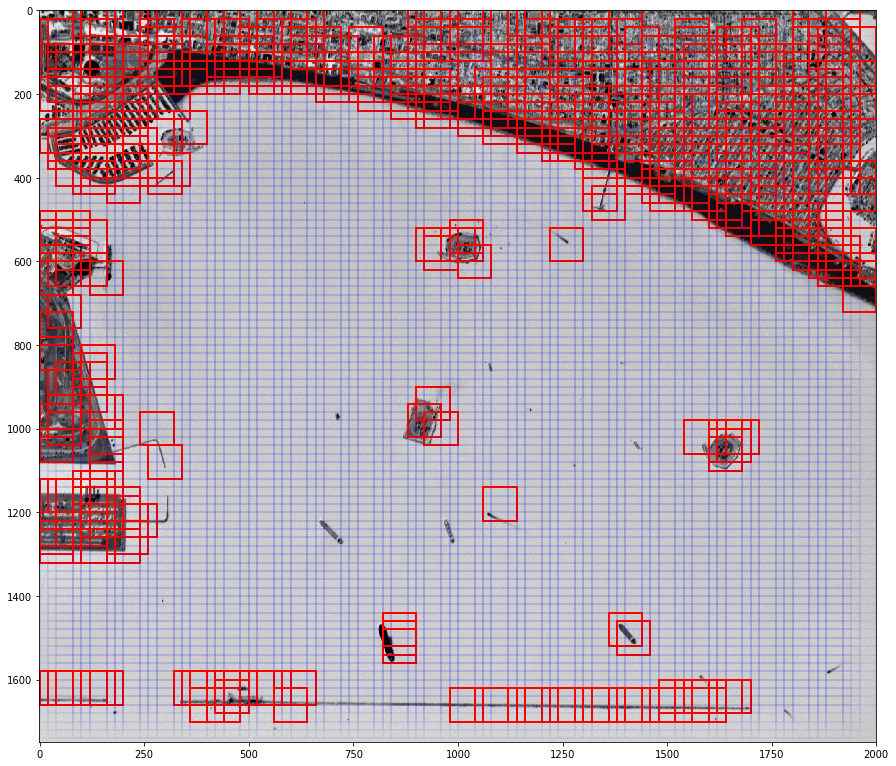

In [15]:
from PIL import Image, ImageOps, ImageFilter
scene1 = Image.open("./scenes/lb_1.png") # open colour image

# scene1 = scene1.filter(ImageFilter.BoxBlur(10))
# scene1_bw = np.asarray(scene1)
# r, g, b = scene1_bw[:,:,0], scene1_bw[:,:,1], scene1_bw[:,:,2]
# scene1_bw = (r+g+b)/3 + 100 # No correct classifications
# scene1_bw[scene1_bw > 255] = 255
# scene1_bw = 0.2989 * r + 0.5870 * g + 0.1140 * b # One correct classification
scene1_bw = np.asarray(ImageOps.grayscale(scene1)) # One correct classification, slightly more accurate.


# Plot Unmarked Black White Image
# plt.figure(figsize=(15,18))
# plt.imshow(scene1_bw, cmap=plt.cm.gray_r, interpolation='nearest')
# plt.axis('off')
# plt.show()

# Create sections of the image to be classified
scene1_dim = scene1_bw.shape
scene1_sections = []
scene1_sections_locations = []
for i in range(scene1_dim[0] // 80): # for each row
    for j in range(scene1_dim[1] // 80): # for each column
#         xy = (i*80, j*80)  # xy coords of the top left point of a sqare
        
        for x_jitter in range(0,80,20):
            for y_jitter in range(0,60,20):
                xy = (i*80+x_jitter, j*80+y_jitter)
                if xy[0]+80 < scene1_dim[0] and xy[1]+80 < scene1_dim[1]:
                    scene1_sections.append(scene1_bw[xy[0]:xy[0]+80, xy[1]:xy[1]+80].reshape(6400))
                    scene1_sections_locations.append(xy)
# np.array(scene1_sections).shape

# Predict
scene1_predictions = clf.predict(scene1_sections)

# Plot Marked Up Image
fig, ax = plt.subplots(figsize=(15,18))
ax.imshow(scene1_bw, cmap=plt.cm.gray_r, interpolation='nearest')
# ax.axis('off')
for index in range(len(scene1_predictions)):
    xy = scene1_sections_locations[index]
    if scene1_predictions[index] == 1:
        ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='red',lw=2, fill=False))
    else:
        ax.add_patch(Rectangle((xy[1],xy[0]), 80, 80, edgecolor='blue',lw=0.05, fill=False))
plt.show()

In [41]:
browse_images(np.array(scene1_sections).reshape([525,80,80]), scene1_predictions, ['Not Boat', 'Boat'])

interactive(children=(IntSlider(value=262, description='i', max=524), Output()), _dom_classes=('widget-interact',))